In [1]:
# pip install gspread google-auth
# pip install TextBlob
# pip install WordCloud

# Import Libraries

In [2]:
# Import Libraries
from bs4 import BeautifulSoup
import requests
import gspread
from google.auth import exceptions
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from googletrans import Translator

from textblob import TextBlob
from wordcloud import WordCloud

import pandas as pd
import matplotlib.pyplot as plt
import time
import plotly.express as px
import seaborn as sns
sns.set_theme(style="white", context="talk")

import pygsheets

# Connect to Google Sheets Data Source

In [3]:
# Connect to Google Sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
gc = pygsheets.authorize(service_file='/Users/asessums/Desktop/belshTourismAnalysis/config/credentials.json')

# Open the Google Sheet by title
spreadsheet_title = '2 / Survey Responses'
worksheet_title = 'englishCopy'


In [4]:
# Open Google Sheets and tell me if successful
try:
    # Attempt to open the Google Sheet
    spreadsheet = gc.open(spreadsheet_title)
    
    # If successful, print the spreadsheet object and success message
    print("Successfully opened sheet:", spreadsheet)
except Exception as e:
    # If an error occurs, print the failure message and the error
    print("Did not open sheet. Error:", e)

Successfully opened sheet: <Spreadsheet '2 / Survey Responses' Sheets:3>


In [5]:
# Select the third sheet
worksheet = spreadsheet[2]

# Get the data as a DataFrame
df = worksheet.get_as_df()

# Print the DataFrame
df.head(5)

,Timestamp,The origin,Gender,Age group,RESIDENCE,How many times have you visited Belsh?,Type of transport used?,Who did you choose to visit Belsh with?,Where did you hear about Belgium as a tourist destination?,What factors push you the most to plan a trip to Belsh?,"How important is the tourist infrastructure (accommodation, transport, restaurants) to you in the decision to travel to Belsh?",What influences your decision to choose Belsh as a tourist destination?,Do you have a personal reference or recommendation from another person to visit Belsh?,How does the presentation of Belsh on social media affect your perception of this tourist destination?,Do you think that the information on the Internet about Belgium is sufficient and accurate to determine if it is a suitable destination for you?,What kind of activities do you prefer to do while visiting Belgium?,How would you describe your recent experience in Belgium in one word?,Is there anything you wish Belshi had to offer but couldn't find it?
0,09/08/2024 08:51:36,DOMESTIC,female,26-35,Fier,more than 3 times,personal vehicle,family,From close,lakes,Very important,Both,"Yes, positive recommendation",Increases interest in visiting,"Yes, but it needs more information",Picnic,Very beautiful,Park for children
1,09/08/2024 09:00:49,DOMESTIC,female,18-25,Tirana,1 time,personal vehicle,family,Social networks,"The lake, the restaurants",Very important,Both,"Yes, positive recommendation",Increases interest in visiting,"Yes, but it needs more information",Tours,enchanting,not
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 time,public transport,social group,From society,The large number of lakes and beautiful nature.,Little important,Disposition of the budget,"Yes, positive recommendation",It doesn't affect my decision,"Yes, but it needs more information",Hiking and sightseeing,"Nice, but the area has a lot more potential",A better infrastructure when it comes to the c...
3,09/08/2024 09:16:22,Foreigners,female,18-25,Colombia,2-3 times,public transport,colleague,From society,Lake,Important,Neither of the above options,"Yes, positive recommendation",I don't use social media,"Yes, but it needs more information",Walk around the lake,All right,With many activities
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,more than 3 times,public transport,social group,Through friends and family,To visit a friend,Important,Both,"Yes, positive recommendation",It doesn't affect my decision,"Yes, but it needs more information","Hiking, walking around the lake, visiting Sefran",Relaxing,"More physical tourism materials, such as a map..."


# Examine Dataframe & Data cleanup

In [6]:
df.shape

(50, 18)

In [7]:
df.describe()

,Timestamp,The origin,Gender,Age group,RESIDENCE,How many times have you visited Belsh?,Type of transport used?,Who did you choose to visit Belsh with?,Where did you hear about Belgium as a tourist destination?,What factors push you the most to plan a trip to Belsh?,"How important is the tourist infrastructure (accommodation, transport, restaurants) to you in the decision to travel to Belsh?",What influences your decision to choose Belsh as a tourist destination?,Do you have a personal reference or recommendation from another person to visit Belsh?,How does the presentation of Belsh on social media affect your perception of this tourist destination?,Do you think that the information on the Internet about Belgium is sufficient and accurate to determine if it is a suitable destination for you?,What kind of activities do you prefer to do while visiting Belgium?,How would you describe your recent experience in Belgium in one word?,Is there anything you wish Belshi had to offer but couldn't find it?
count,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
unique,50,2,2,5,15,3,3,4,10,24,3,4,3,3,4,24,15,24
top,09/08/2024 08:51:36,DOMESTIC,female,26-35,Tirana,more than 3 times,personal vehicle,family,Social networks,Nature,Very important,Both,"Yes, positive recommendation",Increases interest in visiting,"Yes, but it needs more information",Walk around the lake,enchanting,not
freq,1,34,31,19,14,27,36,24,14,9,28,27,44,39,35,8,10,12


In [8]:
# Check for Duplicate Values
df_dropped = df.drop(columns=['Timestamp'])

# Step 1: Concatenate all columns into a single string column
df_dropped['concatenated'] = df_dropped.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Step 2: Check for duplicates in the concatenated column
df_duplicates = df_dropped[df_dropped.duplicated(subset=['concatenated'])]

# Step 3: Display the duplicate rows
if df.empty:
    print("DataFrame is empty. No duplicated values.")
elif df_duplicates.empty:
    print("No duplicated values found.")
else:
    print(f"Number of duplicated rows: {df_duplicates.shape[0]}")
    print(df_duplicates.head(10))

No duplicated values found.


In [9]:
# Dataframe Cleanup
df.rename(columns={'The origin': 'Origin', 'Age group': 'Age Group', 'RESIDENCE': 'Residence', 'How many times have you visited Belsh?': '# of Visits to Belsh'
                   , 'Type of transport used?': 'Transport Type', 'Who did you choose to visit Belsh with?': 'Party Type' 
                   , 'Where did you hear about Belgium as a tourist destination?': 'Source of Visit', 'What factors push you the most to plan a trip to Belsh?': 'Trip Factors'
                   , 'How important is the tourist infrastructure (accommodation, transport, restaurants) to you in the decision to travel to Belsh?': 'Tourism Infrastructure'
                   , 'What influences your decision to choose Belsh as a tourist destination?': 'Influences'
                   , 'Do you have a personal reference or recommendation from another person to visit Belsh?': 'Personal Reference'
                   , 'How does the presentation of Belsh on social media affect your perception of this tourist destination?': 'Social Media Perception'
                   , 'Do you think that the information on the Internet about Belgium is sufficient and accurate to determine if it is a suitable destination for you?': 'Belsh Online Info'
                   , 'What kind of activities do you prefer to do while visiting Belgium?': 'Preferred Activites'
                   , 'How would you describe your recent experience in Belgium in one word?': 'Description'
                   , "Is there anything you wish Belshi had to offer but couldn't find it?": 'Missing'}
                   , inplace=True)

# Print the DataFrame
df.head(5)

,Timestamp,Origin,Gender,Age Group,Residence,# of Visits to Belsh,Transport Type,Party Type,Source of Visit,Trip Factors,Tourism Infrastructure,Influences,Personal Reference,Social Media Perception,Belsh Online Info,Preferred Activites,Description,Missing
0,09/08/2024 08:51:36,DOMESTIC,female,26-35,Fier,more than 3 times,personal vehicle,family,From close,lakes,Very important,Both,"Yes, positive recommendation",Increases interest in visiting,"Yes, but it needs more information",Picnic,Very beautiful,Park for children
1,09/08/2024 09:00:49,DOMESTIC,female,18-25,Tirana,1 time,personal vehicle,family,Social networks,"The lake, the restaurants",Very important,Both,"Yes, positive recommendation",Increases interest in visiting,"Yes, but it needs more information",Tours,enchanting,not
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 time,public transport,social group,From society,The large number of lakes and beautiful nature.,Little important,Disposition of the budget,"Yes, positive recommendation",It doesn't affect my decision,"Yes, but it needs more information",Hiking and sightseeing,"Nice, but the area has a lot more potential",A better infrastructure when it comes to the c...
3,09/08/2024 09:16:22,Foreigners,female,18-25,Colombia,2-3 times,public transport,colleague,From society,Lake,Important,Neither of the above options,"Yes, positive recommendation",I don't use social media,"Yes, but it needs more information",Walk around the lake,All right,With many activities
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,more than 3 times,public transport,social group,Through friends and family,To visit a friend,Important,Both,"Yes, positive recommendation",It doesn't affect my decision,"Yes, but it needs more information","Hiking, walking around the lake, visiting Sefran",Relaxing,"More physical tourism materials, such as a map..."


In [10]:
df = df.applymap(lambda x: x.title() if isinstance(x, str) else x)
df.head(5)

,Timestamp,Origin,Gender,Age Group,Residence,# of Visits to Belsh,Transport Type,Party Type,Source of Visit,Trip Factors,Tourism Infrastructure,Influences,Personal Reference,Social Media Perception,Belsh Online Info,Preferred Activites,Description,Missing
0,09/08/2024 08:51:36,Domestic,Female,26-35,Fier,More Than 3 Times,Personal Vehicle,Family,From Close,Lakes,Very Important,Both,"Yes, Positive Recommendation",Increases Interest In Visiting,"Yes, But It Needs More Information",Picnic,Very Beautiful,Park For Children
1,09/08/2024 09:00:49,Domestic,Female,18-25,Tirana,1 Time,Personal Vehicle,Family,Social Networks,"The Lake, The Restaurants",Very Important,Both,"Yes, Positive Recommendation",Increases Interest In Visiting,"Yes, But It Needs More Information",Tours,Enchanting,Not
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 Time,Public Transport,Social Group,From Society,The Large Number Of Lakes And Beautiful Nature.,Little Important,Disposition Of The Budget,"Yes, Positive Recommendation",It Doesn'T Affect My Decision,"Yes, But It Needs More Information",Hiking And Sightseeing,"Nice, But The Area Has A Lot More Potential",A Better Infrastructure When It Comes To The C...
3,09/08/2024 09:16:22,Foreigners,Female,18-25,Colombia,2-3 Times,Public Transport,Colleague,From Society,Lake,Important,Neither Of The Above Options,"Yes, Positive Recommendation",I Don'T Use Social Media,"Yes, But It Needs More Information",Walk Around The Lake,All Right,With Many Activities
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,More Than 3 Times,Public Transport,Social Group,Through Friends And Family,To Visit A Friend,Important,Both,"Yes, Positive Recommendation",It Doesn'T Affect My Decision,"Yes, But It Needs More Information","Hiking, Walking Around The Lake, Visiting Sefran",Relaxing,"More Physical Tourism Materials, Such As A Map..."


In [11]:
df.isna().sum()

Timestamp                  0
Origin                     0
Gender                     0
Age Group                  0
Residence                  0
# of Visits to Belsh       0
Transport Type             0
Party Type                 0
Source of Visit            0
Trip Factors               0
Tourism Infrastructure     0
Influences                 0
Personal Reference         0
Social Media Perception    0
Belsh Online Info          0
Preferred Activites        0
Description                0
Missing                    0
dtype: int64

In [12]:
# Final step of data cleaning

# Check if the DataFrame is empty
if df.empty:
    print("DataFrame is empty. No data to clean.")
else:
    # Check for blank columns and rows
    blank_columns = df.columns[df.isna().all()].tolist()  # Columns that are entirely blank
    blank_rows = df[df.isna().all(axis=1)].shape[0]  # Count of rows that are entirely blank
    
    # Check for duplicate values
    df_dropped = df.drop(columns=['Timestamp'])  # Assuming you already dropped the Timestamp column
    df_dropped['concatenated'] = df_dropped.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    df_duplicates = df_dropped[df_dropped.duplicated(subset=['concatenated'])]
    num_duplicates = df_duplicates.shape[0]  # Number of duplicated rows
    
    # Count total blank values in the DataFrame
    total_blank_values = df.isna().sum().sum()  # Total number of blank values in the DataFrame
    
    # Print results
    print("DataFrame cleaning is complete.")
    print(f"The DataFrame has {blank_rows} blank rows.")
    print(f"The DataFrame has {blank_columns} blank columns.")
    
    if num_duplicates > 0:
        print(f"There are {num_duplicates} duplicated rows.")
    else:
        print("No duplicated values found.")
    
    print(f"There are {total_blank_values} total blank values in the DataFrame.")

DataFrame cleaning is complete.
The DataFrame has 0 blank rows.
The DataFrame has [] blank columns.
No duplicated values found.
There are 0 total blank values in the DataFrame.


# Data Analysis

## Who's coming to Belsh?

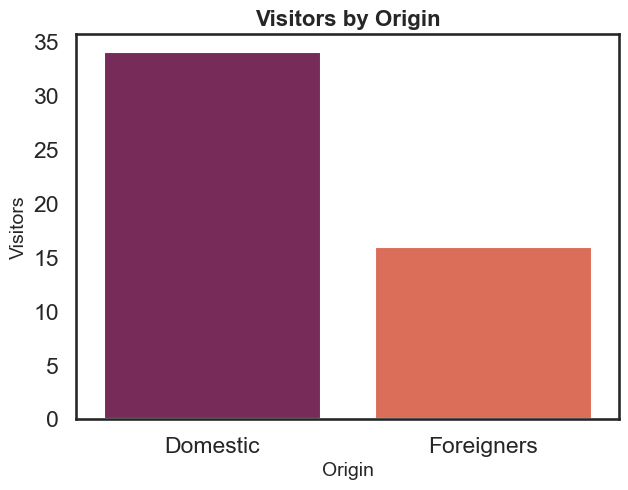

In [15]:
# Distribution of Visitors by Origin | Domestic vs. Foreign
plt.figure(figsize=(7, 5))

# Create a count plot using Seaborn
ax = sns.countplot(data=df, x='Origin', palette="rocket")

# Set the title and labels
ax.set_title('Visitors by Origin', fontsize=16, fontweight='bold', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel('Origin', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Step 5: Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/visitorOrigin.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

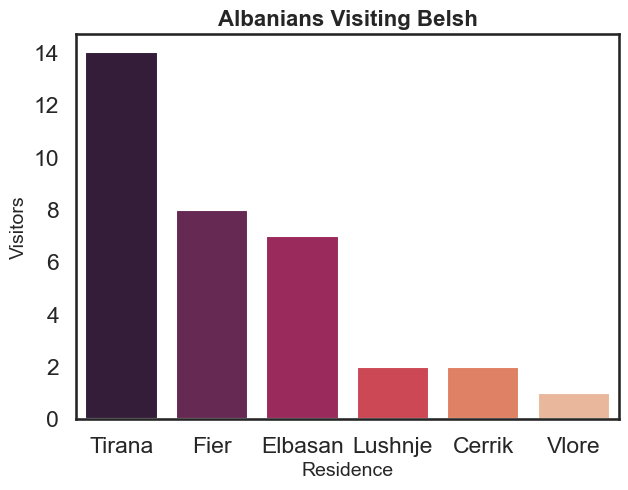

In [17]:
# Calculate the total counts for each factor | Albanians Visiting Belsh
domestic_df = df[df['Origin'] == 'Domestic']

# Sort the factors in descending order based on the counts
residence_counts = domestic_df['Residence'].value_counts().reset_index()
residence_counts.columns = ['Residence', 'Count']
residence_counts = residence_counts.sort_values(by='Count', ascending=False)

# Domestic Tourist Count by Origin
plt.figure(figsize=(7, 5))

# Create a count plot using Seaborn
ax = sns.barplot(data=residence_counts, x='Residence', y='Count', palette="rocket", order=residence_counts['Residence'])

# Set the title and labels
ax.set_title('Albanians Visiting Belsh', fontsize=16, fontweight='bold', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel('Residence', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Step 5: Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/domesticVisitorOrigin.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

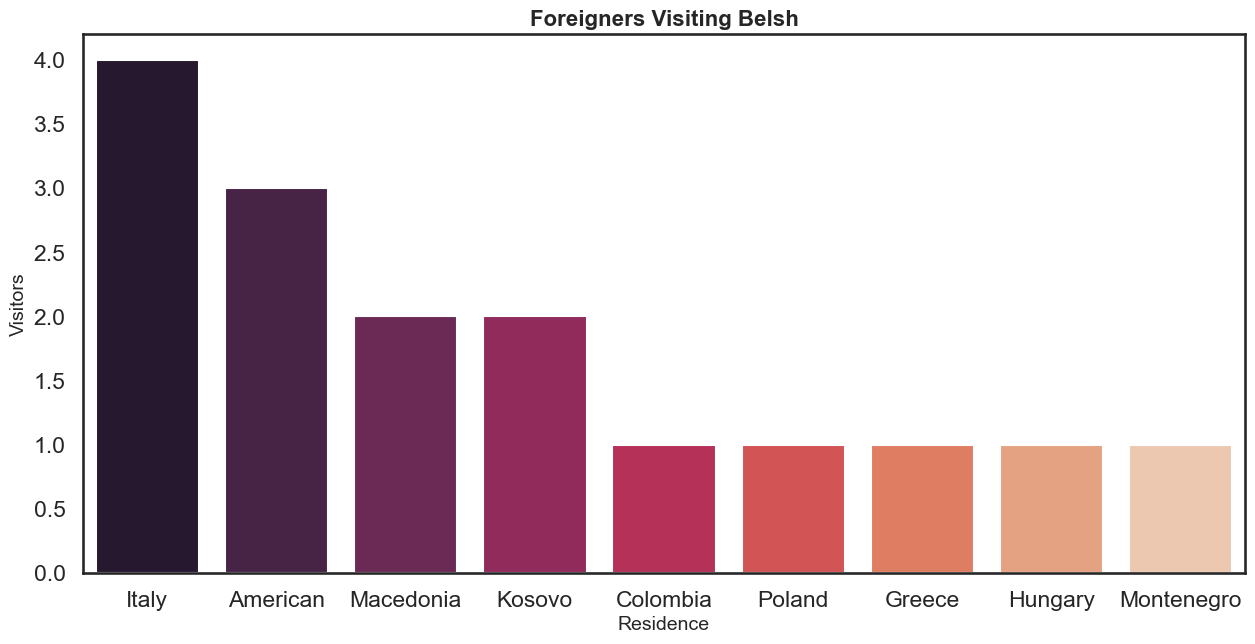

In [18]:
# Calculate the total counts for each factor
foreign_df = df[df['Origin'] == 'Foreigners']

# Sort the factors in descending order based on the counts
residence_counts = foreign_df['Residence'].value_counts().reset_index()
residence_counts.columns = ['Residence', 'Count']
residence_counts = residence_counts.sort_values(by='Count', ascending=False)

# Domestic Tourist Count by Origin
plt.figure(figsize=(15, 7))

# Create a count plot using Seaborn
ax = sns.barplot(data=residence_counts, x='Residence', y='Count', palette="rocket", order=residence_counts['Residence'])

# Set the title and labels
ax.set_title('Foreigners Visiting Belsh', fontsize=16, fontweight='bold', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel('Residence', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Step 5: Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/foreignVisitorOrigin.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

/var/folders/tb/8n29tk616h3_0cwcyyfldbfc0000gn/T/ipykernel_12126/1863677566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreign_df['Region'] = foreign_df['Residence'].map(region_mapping)


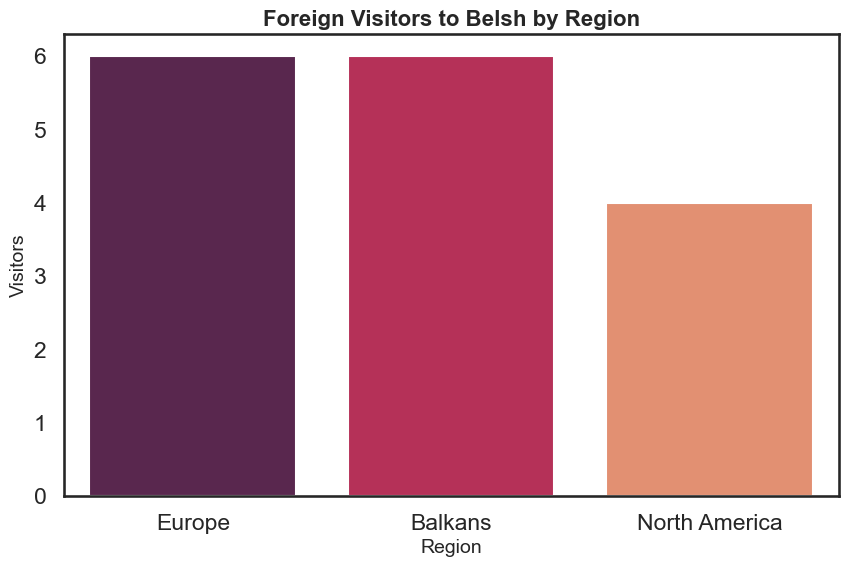

In [19]:
# Define the mapping of countries to regions
region_mapping = {
    'American': 'North America', 'Canada': 'North America', 'Colombia': 'North America',  # North America
    'UK': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Poland': 'Europe',  'Hungary': 'Europe', # Europe
    'Albania': 'Balkans', 'Kosovo': 'Balkans', 'Serbia': 'Balkans', 'Macedonia': 'Balkans', 'Montenegro': 'Balkans', 'Greece': 'Balkans', # Balkans
    # Add more countries as needed
}

# Map the Residence column to regions
foreign_df['Region'] = foreign_df['Residence'].map(region_mapping)

# Calculate the total counts for each region
region_counts = foreign_df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']
region_counts = region_counts.sort_values(by='Count', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))

# Create a bar plot using Seaborn
ax = sns.barplot(data=region_counts, x='Region', y='Count', palette="rocket")

# Set the title and labels
ax.set_title('Foreign Visitors to Belsh by Region', fontsize=16, fontweight='bold')
ax.set_xlabel('Region', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/foreignVisitorByRegion.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

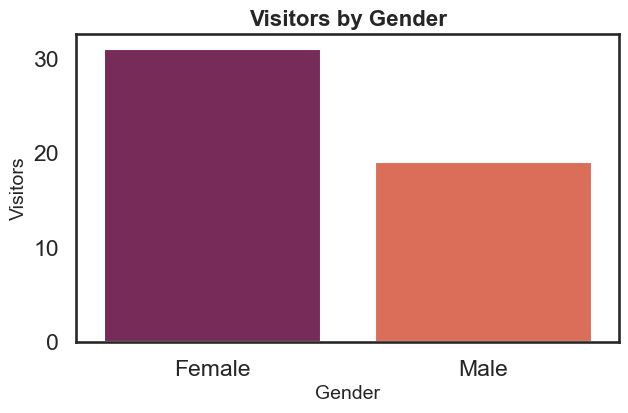

In [20]:
# Gender Distribution of Tourists
# Set the figure size (width, height)
plt.figure(figsize=(7, 4)) 

# Create a count plot using Seaborn
ax = sns.countplot(data=df, x='Gender', palette="rocket")

# Set the title and labels
ax.set_title('Visitors by Gender', fontsize=16, fontweight='bold', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Step 5: Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/visitorGender.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

## How do people hear about Belsh?

In [24]:
# Feature Creation
# Define functions to detect the presence of each category in the responses
df['Personal Network'] = df['Source of Visit'].str.contains('friend|Friends|family|close|colleagues|society', case=False, na=False).astype(int)
df['Tourist Agency'] = df['Source of Visit'].str.contains('tourist agency|info point', case=False, na=False).astype(int)
df['Random/Pass By'] = df['Source of Visit'].str.contains('passed by', case=False, na=False).astype(int)
df['Social Media'] = df['Source of Visit'].str.contains('social networks', case=False, na=False).astype(int)

# Preview the new DataFrame with numeric columns
df.head(5)

,Timestamp,Origin,Gender,Age Group,Residence,# of Visits to Belsh,Transport Type,Party Type,Source of Visit,Trip Factors,...,Personal Reference,Social Media Perception,Belsh Online Info,Preferred Activites,Description,Missing,Personal Network,Tourist Agency,Random/Pass By,Social Media
0,09/08/2024 08:51:36,Domestic,Female,26-35,Fier,More Than 3 Times,Personal Vehicle,Family,From Close,Lakes,...,"Yes, Positive Recommendation",Increases Interest In Visiting,"Yes, But It Needs More Information",Picnic,Very Beautiful,Park For Children,1,0,0,0
1,09/08/2024 09:00:49,Domestic,Female,18-25,Tirana,1 Time,Personal Vehicle,Family,Social Networks,"The Lake, The Restaurants",...,"Yes, Positive Recommendation",Increases Interest In Visiting,"Yes, But It Needs More Information",Tours,Enchanting,Not,0,0,0,1
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 Time,Public Transport,Social Group,From Society,The Large Number Of Lakes And Beautiful Nature.,...,"Yes, Positive Recommendation",It Doesn'T Affect My Decision,"Yes, But It Needs More Information",Hiking And Sightseeing,"Nice, But The Area Has A Lot More Potential",A Better Infrastructure When It Comes To The C...,1,0,0,0
3,09/08/2024 09:16:22,Foreigners,Female,18-25,Colombia,2-3 Times,Public Transport,Colleague,From Society,Lake,...,"Yes, Positive Recommendation",I Don'T Use Social Media,"Yes, But It Needs More Information",Walk Around The Lake,All Right,With Many Activities,1,0,0,0
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,More Than 3 Times,Public Transport,Social Group,Through Friends And Family,To Visit A Friend,...,"Yes, Positive Recommendation",It Doesn'T Affect My Decision,"Yes, But It Needs More Information","Hiking, Walking Around The Lake, Visiting Sefran",Relaxing,"More Physical Tourism Materials, Such As A Map...",1,0,0,0


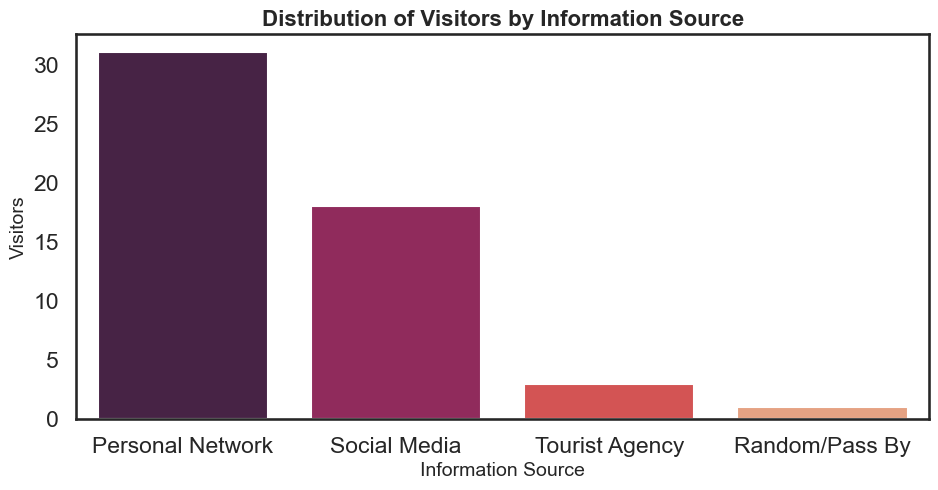

In [25]:
# Information Source About Belsh
# Melt the DataFrame to create a long-form DataFrame suitable for seaborn
df_melted = df.melt(id_vars=['Source of Visit'], 
                    value_vars=['Personal Network', 'Tourist Agency', 'Random/Pass By', 'Social Media'],
                    var_name='Source', value_name='Count')

# Filter the melted DataFrame for rows where 'Count' is 1 (i.e., the source was present)
df_melted = df_melted[df_melted['Count'] == 1]

# Distribution of Visitors by Source
plt.figure(figsize=(11, 5))

# Create a count plot using Seaborn
ax = sns.countplot(data=df_melted, x='Source', palette="rocket", order=df_melted['Source'].value_counts().index)

# Set the title and labels
ax.set_title('Distribution of Visitors by Information Source', fontsize=16, fontweight='bold')
ax.set_xlabel('Information Source', fontsize=14)
ax.set_ylabel('Visitors', fontsize=14)

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/visitorInformationSource.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Why are visitors coming to Belsh?

In [26]:
# Define functions to detect the presence of each category in the responses
df['Lakes'] = df['Trip Factors'].str.contains('lake|Lakes', case=False, na=False).astype(int)
df['Nature'] = df['Trip Factors'].str.contains('nature|view|views|hilly|scenery', case=False, na=False).astype(int)
df['Agrotourism'] = df['Trip Factors'].str.contains('agrotourism', case=False, na=False).astype(int)
df['Food/Restaurants'] = df['Trip Factors'].str.contains('food|restaurant|restaurants|cuisine', case=False, na=False).astype(int)
df['Family/Quiet Time'] = df['Trip Factors'].str.contains('quiet|family', case=False, na=False).astype(int)
df['Social'] = df['Trip Factors'].str.contains('friend|passing by', case=False, na=False).astype(int)

# Preview the new DataFrame with numeric columns
df.head(5)

,Timestamp,Origin,Gender,Age Group,Residence,# of Visits to Belsh,Transport Type,Party Type,Source of Visit,Trip Factors,...,Personal Network,Tourist Agency,Random/Pass By,Social Media,Lakes,Nature,Agrotourism,Food/Restaurants,Family/Quiet Time,Social
0,09/08/2024 08:51:36,Domestic,Female,26-35,Fier,More Than 3 Times,Personal Vehicle,Family,From Close,Lakes,...,1,0,0,0,1,0,0,0,0,0
1,09/08/2024 09:00:49,Domestic,Female,18-25,Tirana,1 Time,Personal Vehicle,Family,Social Networks,"The Lake, The Restaurants",...,0,0,0,1,1,0,0,1,0,0
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 Time,Public Transport,Social Group,From Society,The Large Number Of Lakes And Beautiful Nature.,...,1,0,0,0,1,1,0,0,0,0
3,09/08/2024 09:16:22,Foreigners,Female,18-25,Colombia,2-3 Times,Public Transport,Colleague,From Society,Lake,...,1,0,0,0,1,0,0,0,0,0
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,More Than 3 Times,Public Transport,Social Group,Through Friends And Family,To Visit A Friend,...,1,0,0,0,0,0,0,0,0,1


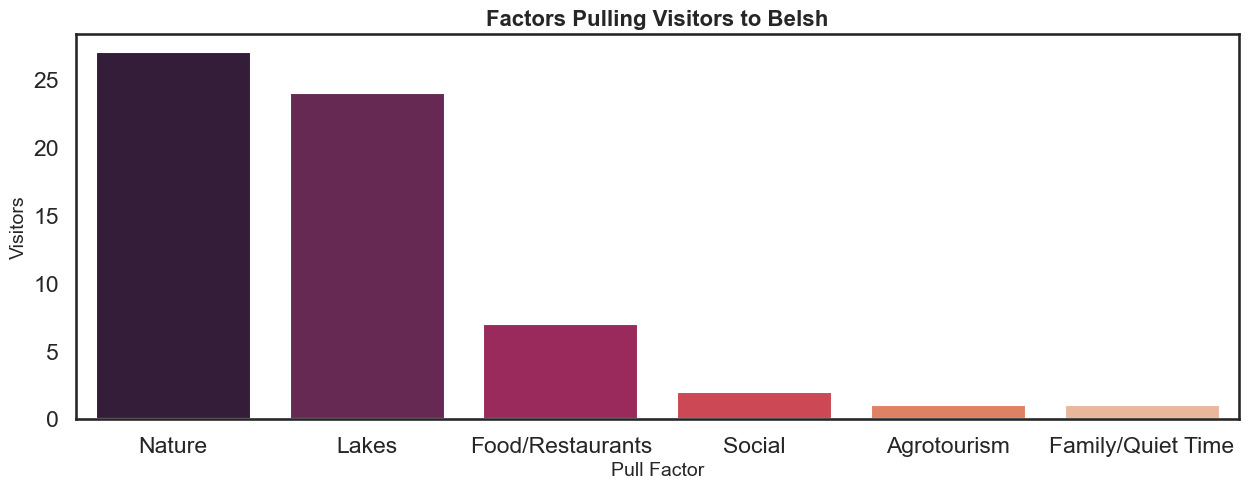

In [27]:
# Melt the DataFrame to create a long-form DataFrame
df_melted = df.melt(id_vars=['Trip Factors'], 
                    value_vars=['Lakes', 'Nature', 'Agrotourism', 'Food/Restaurants', 'Family/Quiet Time', 'Social'],
                    var_name='Factor', value_name='Count')

# Set the figure size (width, height)
plt.figure(figsize=(15, 5)) 

# Calculate the total counts for each factor
factor_counts = df_melted[df_melted['Count'] == 1].groupby('Factor').size().reset_index(name='Total')

# Sort the factors in descending order based on the counts
sorted_factors = factor_counts.sort_values(by='Total', ascending=False)['Factor']

# Create a count plot
sns.countplot(data=df_melted[df_melted['Count'] == 1], x='Factor', palette="rocket", order=sorted_factors)
plt.title('Factors Pulling Visitors to Belsh', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Visitors', fontsize=14)
plt.xlabel('Pull Factor', fontsize=14)
# plt.xticks(rotation=45)

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/factorsPlot.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

# How are visitors getting to Belsh?

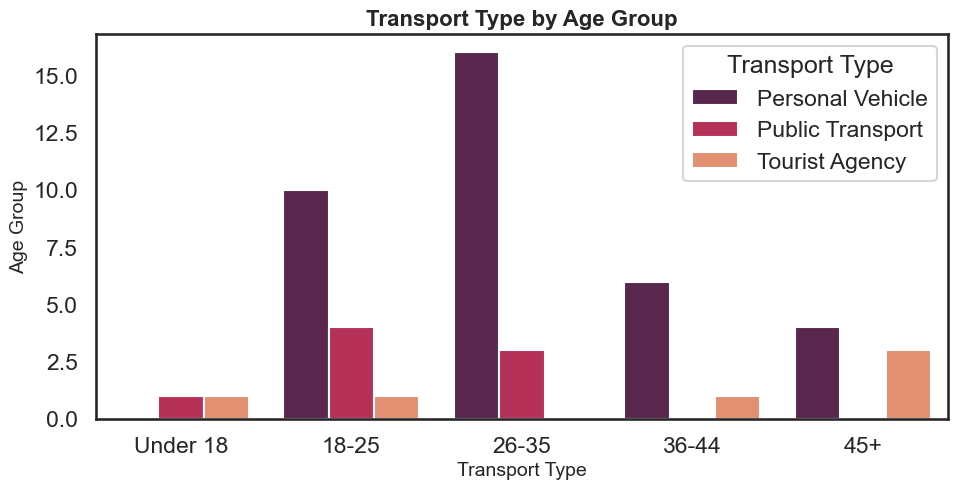

In [28]:
# Set the figure size (width, height)
plt.figure(figsize=(11, 5)) 

age_group_order = ['Under 18', '18-25', '26-35', '36-44', '45+'] 

# Age Group vs. Transport Type
sns.countplot(x='Age Group', hue='Transport Type', data=df, palette='rocket', order=age_group_order)

plt.title('Transport Type by Age Group', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Age Group', fontsize=14)
plt.xlabel('Transport Type', fontsize=14)
# plt.xticks(rotation=45)

# Adjust the legend position
plt.legend(title='Transport Type', bbox_to_anchor=(1, 1), loc='upper right')

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/transportAgeGroupPlot.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

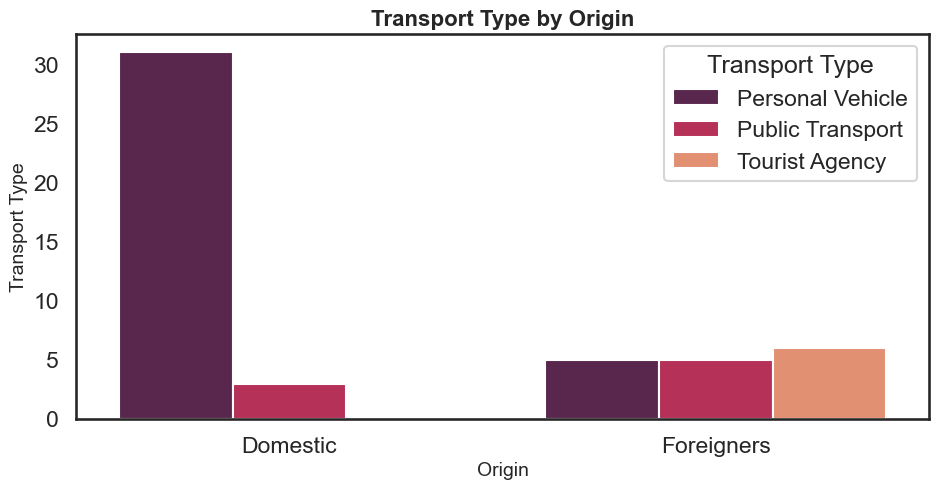

In [29]:
# Set the figure size (width, height)
plt.figure(figsize=(11, 5)) 

# Age Group vs. Transport Type
sns.countplot(x='Origin', hue='Transport Type', data=df, palette='rocket')

plt.title('Transport Type by Origin', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Transport Type', fontsize=14)
plt.xlabel('Origin', fontsize=14)
# plt.xticks(rotation=45)

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/transportOriginPlot.jpg', dpi=300, bbox_inches='tight')

# Step 6: Show the plot
plt.show()

## What are Visitors Doing in Belsh?

In [30]:
# Define functions to detect the presence of each category in the responses
df['Lake Activities (Not Board Ride)'] = df['Preferred Activites'].str.contains('lake|Lakes|fishing|picnic|Sefran', case=False, na=False).astype(int)
df['Boat Ride'] = df['Preferred Activites'].str.contains('boat|boating', case=False, na=False).astype(int)
df['Hiking'] = df['Preferred Activites'].str.contains('hiking|hikes', case=False, na=False).astype(int)
df['Food/Cafes/Picnics'] = df['Preferred Activites'].str.contains('food|cafe|cafes|restaurants|picnic', case=False, na=False).astype(int)
df['Tours'] = df['Preferred Activites'].str.contains('tour|Tours', case=False, na=False).astype(int)

# Preview the new DataFrame with numeric columns
df.head(5)

,Timestamp,Origin,Gender,Age Group,Residence,# of Visits to Belsh,Transport Type,Party Type,Source of Visit,Trip Factors,...,Nature,Agrotourism,Food/Restaurants,Family/Quiet Time,Social,Lake Activities (Not Board Ride),Boat Ride,Hiking,Food/Cafes/Picnics,Tours
0,09/08/2024 08:51:36,Domestic,Female,26-35,Fier,More Than 3 Times,Personal Vehicle,Family,From Close,Lakes,...,0,0,0,0,0,1,0,0,1,0
1,09/08/2024 09:00:49,Domestic,Female,18-25,Tirana,1 Time,Personal Vehicle,Family,Social Networks,"The Lake, The Restaurants",...,0,0,1,0,0,0,0,0,0,1
2,09/08/2024 09:13:24,Foreigners,Male,18-25,American,1 Time,Public Transport,Social Group,From Society,The Large Number Of Lakes And Beautiful Nature.,...,1,0,0,0,0,0,0,1,0,0
3,09/08/2024 09:16:22,Foreigners,Female,18-25,Colombia,2-3 Times,Public Transport,Colleague,From Society,Lake,...,0,0,0,0,0,1,0,0,0,0
4,09/08/2024 10:16:56,Foreigners,Male,26-35,American,More Than 3 Times,Public Transport,Social Group,Through Friends And Family,To Visit A Friend,...,0,0,0,0,1,1,0,1,0,0


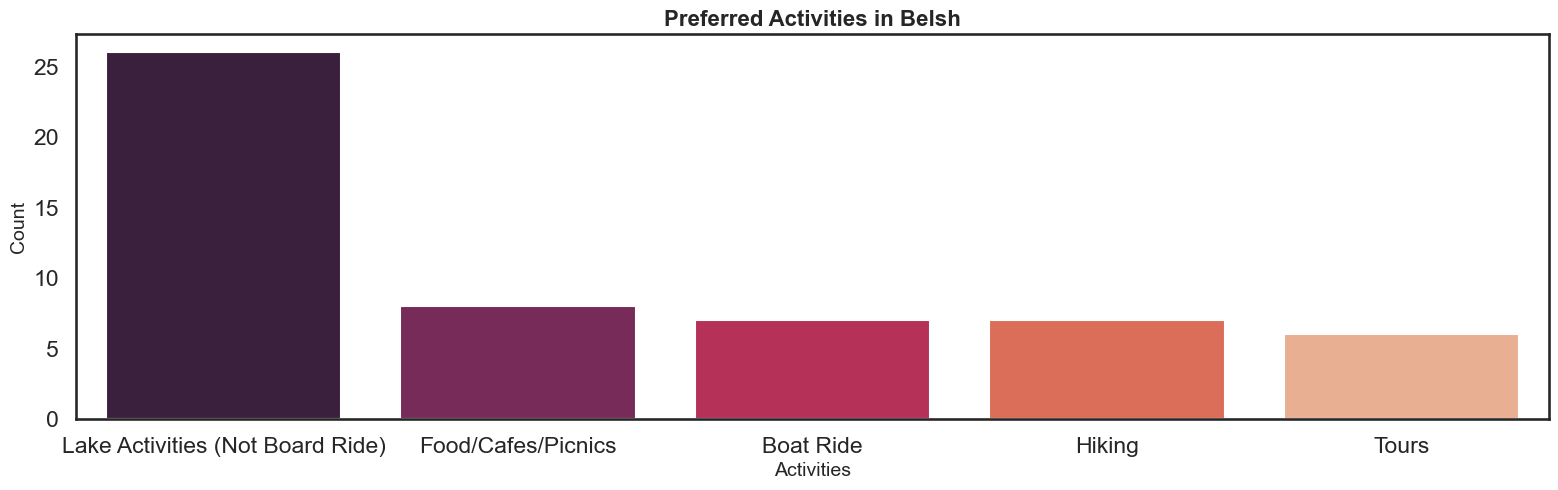

In [32]:
# Melt the DataFrame to create a long-form DataFrame
df_melted = df.melt(id_vars=['Preferred Activites'], 
                    value_vars=['Lake Activities (Not Board Ride)', 'Boat Ride', 'Hiking', 'Food/Cafes/Picnics', 'Tours'],
                    var_name='Activities', value_name='Count')

# Calculate the total counts for each activity
activity_counts = df_melted[df_melted['Count'] == 1].groupby('Activities').size().reset_index(name='Total')

# Sort the activities in descending order based on the counts
sorted_activities = activity_counts.sort_values(by='Total', ascending=False)['Activities']

# Set the figure size (width, height)
plt.figure(figsize=(19, 5)) 

# Create a count plot using the sorted activities order
sns.countplot(data=df_melted[df_melted['Count'] == 1], x='Activities', palette="rocket", order=sorted_activities)

# Set the title and labels
plt.title('Preferred Activities in Belsh', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Count', fontsize=14)
plt.xlabel('Activities', fontsize=14)
# plt.xticks(rotation=45)

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/factorsPlot.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

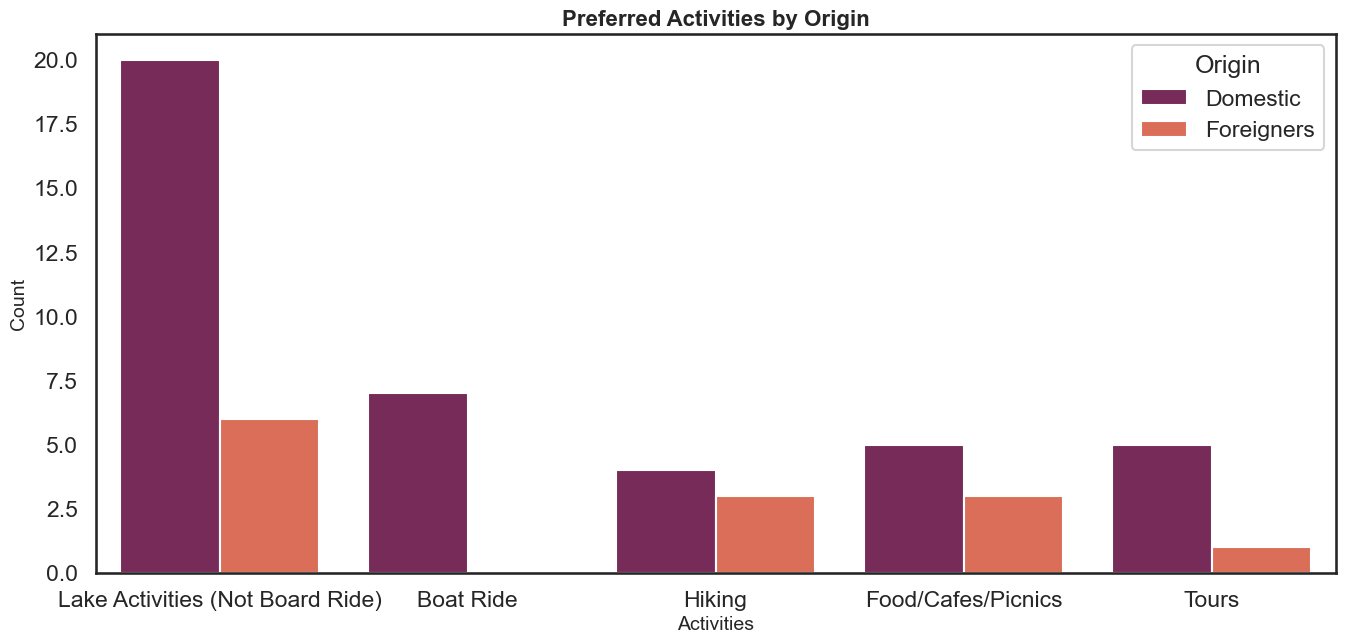

In [33]:
# Define functions to detect the presence of each category in the responses
df['Lake Activities (Not Board Ride)'] = df['Preferred Activites'].str.contains('lake|Lakes|fishing|picnic|Sefran', case=False, na=False).astype(int)
df['Boat Ride'] = df['Preferred Activites'].str.contains('boat|boating', case=False, na=False).astype(int)
df['Hiking'] = df['Preferred Activites'].str.contains('hiking|hikes', case=False, na=False).astype(int)
df['Food/Cafes/Picnics'] = df['Preferred Activites'].str.contains('food|cafe|cafes|restaurants|picnic', case=False, na=False).astype(int)
df['Tours'] = df['Preferred Activites'].str.contains('tour|Tours', case=False, na=False).astype(int)

# Melt the DataFrame to create a long-form DataFrame
df_melted = df.melt(id_vars=['Origin'], 
                    value_vars=['Lake Activities (Not Board Ride)', 'Boat Ride', 'Hiking', 'Food/Cafes/Picnics', 'Tours'],
                    var_name='Activities', value_name='Count')

# Filter to include only rows where Count == 1
df_filtered = df_melted[df_melted['Count'] == 1]

# Plot the data
plt.figure(figsize=(16, 7))

# Create a count plot using Seaborn
ax = sns.countplot(x='Activities', hue='Origin', data=df_filtered, palette='rocket')

# Set the title and labels
plt.title('Preferred Activities by Origin', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Activities', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust the legend position
plt.legend(title='Origin', bbox_to_anchor=(1, 1), loc='upper right')

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/preferredActivitiesByOriginPlot.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## How do visitors feel about their visit to Belsh?

In [34]:
# Function to get sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify as positive, negative, or neutral based on polarity
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment function to your data
df['Sentiment'] = df['Description'].apply(get_sentiment)


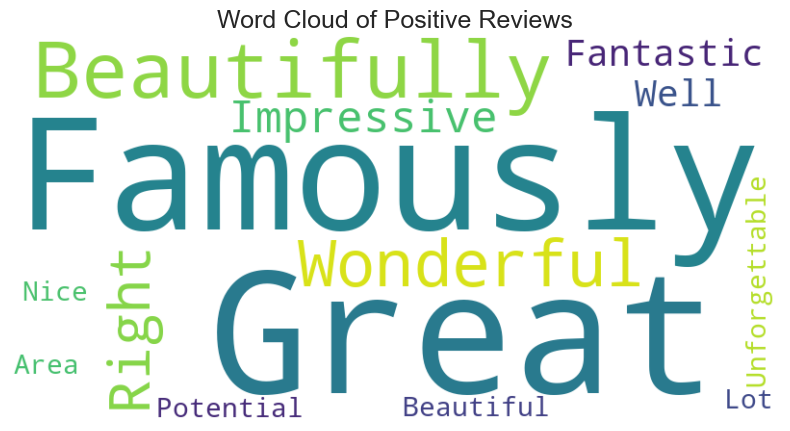

In [35]:
# Generate a word cloud for positive reviews
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Description'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the word cloud``
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/positiveSentimentWordCloud.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

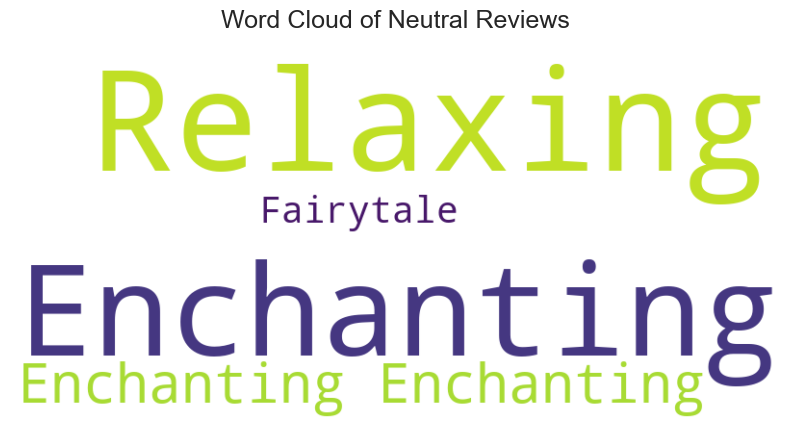

In [36]:
# Generate a word cloud for neutral reviews
positive_text = ' '.join(df[df['Sentiment'] == 'Neutral']['Description'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the word cloud``
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Reviews')

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/neutralSentimentWordCloud.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## What is Missing in Belsh?

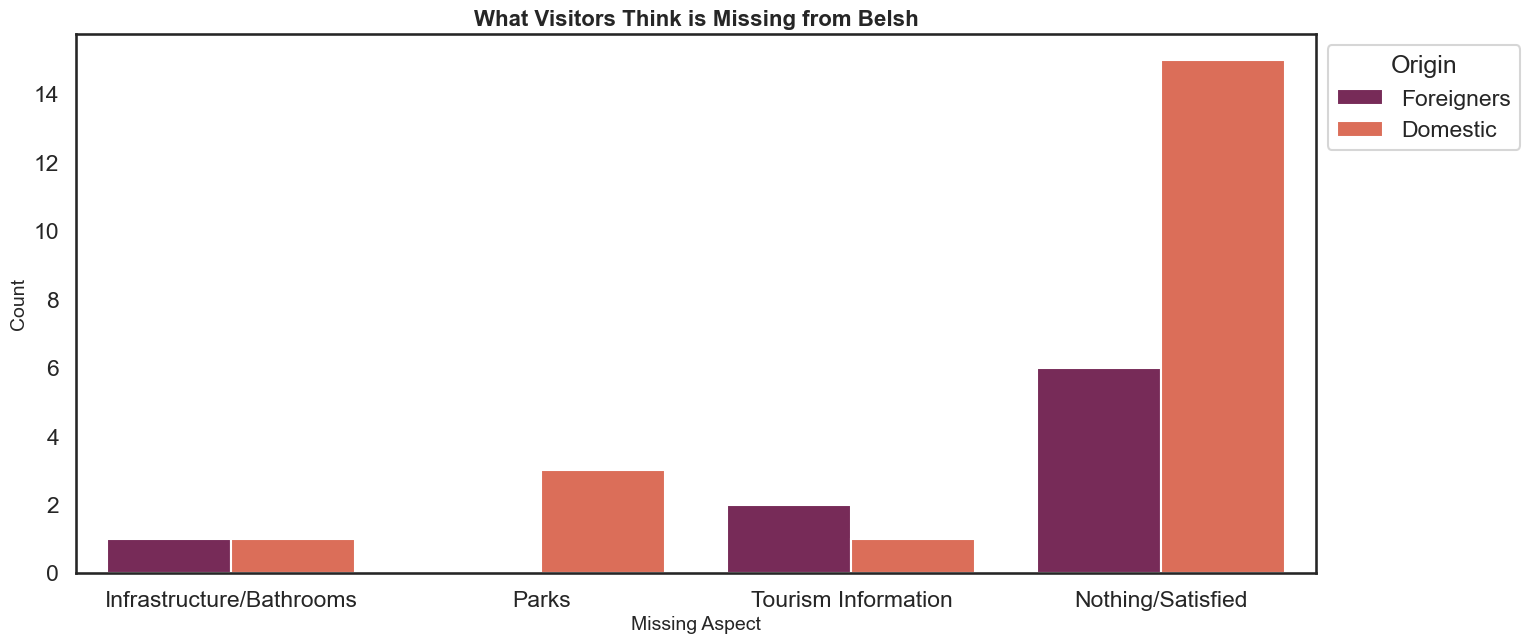

In [37]:
# Define functions to detect the presence of each category in the responses
df['Infrastructure/Bathrooms'] = df['Missing'].str.contains('infrastructure|bathrooms', case=False, na=False).astype(int)
df['Tours'] = df['Missing'].str.contains('visitis', case=False, na=False).astype(int)
df['Parks'] = df['Missing'].str.contains('park|park for children', case=False, na=False).astype(int)
df['Tourism Information'] = df['Missing'].str.contains('brochures|info point', case=False, na=False).astype(int)
df['Nothing/Satisfied'] = df['Missing'].str.contains('satisfied|not|nothing|fine|everything is perfect|pretty good', case=False, na=False).astype(int)

# Melt the DataFrame to create a long-form DataFrame
df_melted = df.melt(id_vars=['Origin'], 
                    value_vars=['Infrastructure/Bathrooms', 'Tours', 'Parks', 'Tourism Information', 'Nothing/Satisfied'],
                    var_name='Missing', value_name='Count')

# Filter to include only rows where Count == 1
df_filtered = df_melted[df_melted['Count'] == 1]

# Plot the data
plt.figure(figsize=(16, 7))

# Create a count plot using Seaborn
ax = sns.countplot(x='Missing', hue='Origin', data=df_filtered, palette='rocket')

# Set the title and labels
plt.title('What Visitors Think is Missing from Belsh', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Missing Aspect', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust the legend position
plt.legend(title='Origin', bbox_to_anchor=(1, 1), loc='upper left')

# Save the plot
plt.savefig('/Users/asessums/Desktop/belshTourismAnalysis/plots/whatVisitorsThinkIsMissingPlot.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
